# Abalone: Oceans Phenomenon

*DSCI 100 006 2022W2 - Group Project Proposal - Group 22*

# TODOs
*You can use `ctrl+F` with "TODO" to locate all the TODOs, but they are here otherwise:*

- INTRO -- why did we choose the factors we did (include a source)

- METHODS>PRELIM ANALYSIS -- include explanation after all viz, and include figure and table labels

- METHODS>CLASSIFICATION -- correct explanation around $k$ and optimize

- METHODS>VIZ -- complete the viz

- DISCUSSION -- complete the first 2 questions based off the results found in METHODS

- SOURCES -- to be compiled

## Introduction

**Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal**
- Abalones are large sea snails found in coastal salt water of New Zealand, Australia, South Africa, Japan and the west coast of North America. Abalone is considered a culinary delicacy but was nearly brought to extinction. As such, harvesting abalones are now under strict regulations.

*How can we apply classification to abalones?*
- Abalone is classified into 3 categories of gender: male, female and infant. Male and female classification is important for economic purposes while the infant category was established in an effort to maintain abalone sustainability.

**Clearly state the question you will try to answer with your project**

`Question:` *Can we accurately predict the effective gender of a given abalone using factors of length, diameter, height, and weight?*
- As stated above, we will define ‘effective gender’ as falling into one of three categories, male, female, and infant. The classification of abalone gender will be determined by factors of height, diameter, whole weight, and length.
- We will define a reasonable accuracy to be around $80\%$ for our data analysis.

**Identify and describe the dataset that will be used to answer the question**
- The data set used for this project is the abalone data set provided by [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone). The dataset provides multiple continuous data such as length, diameter, height, whole weight, shucked weight and shell weight as well as nominal data of gender. As such, this dataset is optimal for a classification problem.


In [1]:
# !!! TODO
"The proposal is also missing an explanation as to why the variables were chosen - use some relevant sources for this."

[1] "The proposal is also missing an explanation as to why the variables were chosen - use some relevant sources for this."

## Methods & Results - Preliminary exploratory data analysis

- We will first load the necessary packages to perform our processes. We will also set the seed so that our functions are reproducible.

In [2]:
### Run this cell before continuing. 
library(repr)
library(tidyverse)
library(tidymodels)

options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

- We will conduct our data analysis by first loading our abalone data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone). Since the dataset did not include column names, we will `rename` them and set the correct data types for `sex` (as a factor) and `rings` (as integer).

In [3]:
## READING AND TIDYING

url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"

# read, rename, and mutate as needed
abalone <-  read_csv(url, col_names = FALSE) |>
        rename(sex = X1,
               length = X2,
               diameter = X3,
               height = X4,
               weight = X5, # weight == whole_weight but as we are ignoring the rest we name it as such
               shucked_weight = X6,
               viscera_weight = X7,
               shell_weight = X8,
               rings = X9) |>
        mutate(sex = as.factor(sex), rings = as.integer(rings))

abalone

Rows: 4177 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): X1
dbl (8): X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,length,diameter,height,weight,shucked_weight,viscera_weight,shell_weight,rings
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.308,9
F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.296,10
M,0.710,0.555,0.195,1.9485,0.9455,0.3765,0.495,12


- With the data now tidy, we can `select` the factors we will need for prediction: `sex, length, diameter, height`, and `width`.

In [4]:
# select the cols with our predictors         
abalone <- abalone |>
    select(sex, length, diameter, height, weight)

abalone

sex,length,diameter,height,weight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140
M,0.350,0.265,0.090,0.2255
F,0.530,0.420,0.135,0.6770
⋮,⋮,⋮,⋮,⋮
M,0.600,0.475,0.205,1.1760
F,0.625,0.485,0.150,1.0945
M,0.710,0.555,0.195,1.9485


- We will then divide our data into $75\%$ training data and $25\%$ testing data with respect to `sex`.

In [5]:
## SPLITTING THE DATA
set.seed(3000)

abalone_split <- initial_split(abalone, prop=0.75, strata=sex)
abalone_train <- training(abalone_split)
abalone_test <- testing(abalone_split)

- With our training data established, we can determine the counts of each `sex` factor to get a better idea of the amount of data we are dealing with, and the proportions of each. 

In [6]:
## SUMMARIZING BY COUNT

abalone_counts <- abalone_train |>
        group_by(sex) |>
        summarize(count = n()) |>
        arrange(by=desc(count))

abalone_counts

sex,count
<fct>,<int>
M,1146
I,1006
F,980


- Now using the training data, we can summarize the mean for each factor of length, diameter, height, and weight, putting this into a data frame named `abalone_summarize`.

In [7]:
## GRAPHING: HEIGHT VS. WEIGHT BY SEX

options(repr.plot.width = 8, repr.plot.height = 4)

abalone_summarize <- abalone_train |>
        group_by(sex) |>
        summarize(
            mean_length = mean(length),
            mean_diameter = mean(diameter),
            mean_height = mean(height),
            mean_weight = mean(weight)
        )

abalone_summarize

sex,mean_length,mean_diameter,mean_height,mean_weight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
F,0.5793929,0.4552602,0.1585102,1.0492204
I,0.4263718,0.3255219,0.1076590,0.4317271
M,0.5625829,0.4402138,0.1510428,0.9930345


- With those metrics established, we can create a bar graph for each factor, comparing the 3 genders of female, male, and infant. Let's graph the `mean_length`, for example. We will also want to reorder our $y$-axis from largest to smallest mean length:

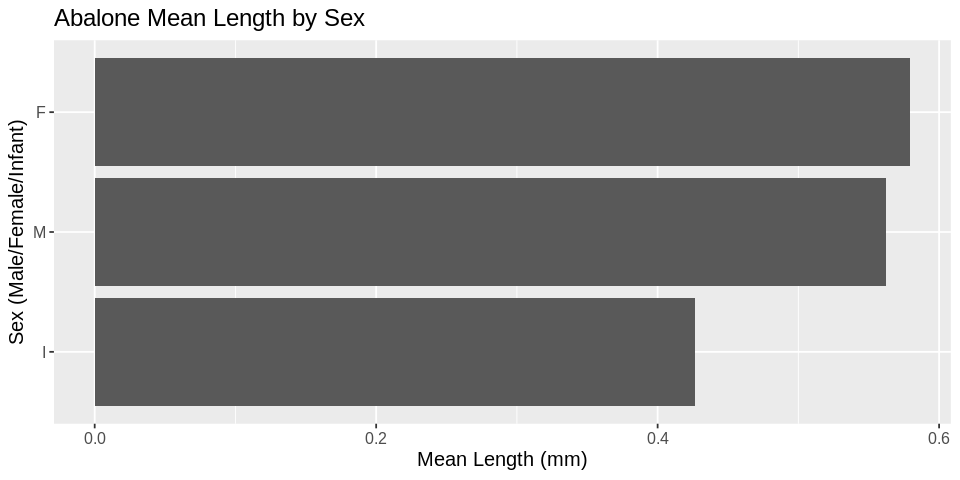

In [8]:
abalone_graph_length <- abalone_summarize |>
        ggplot(aes(x=mean_length, 
                   y=fct_reorder(sex, mean_length))) +
        geom_bar(stat="identity") +
        labs(x = "Mean Length (mm)", y = "Sex (Male/Female/Infant)", title="Abalone Mean Length by Sex") +
        theme(text = element_text(size = 12))

abalone_graph_length

- We can create similar graphs for our other factors of `diameter`, `height`, and `weight`:

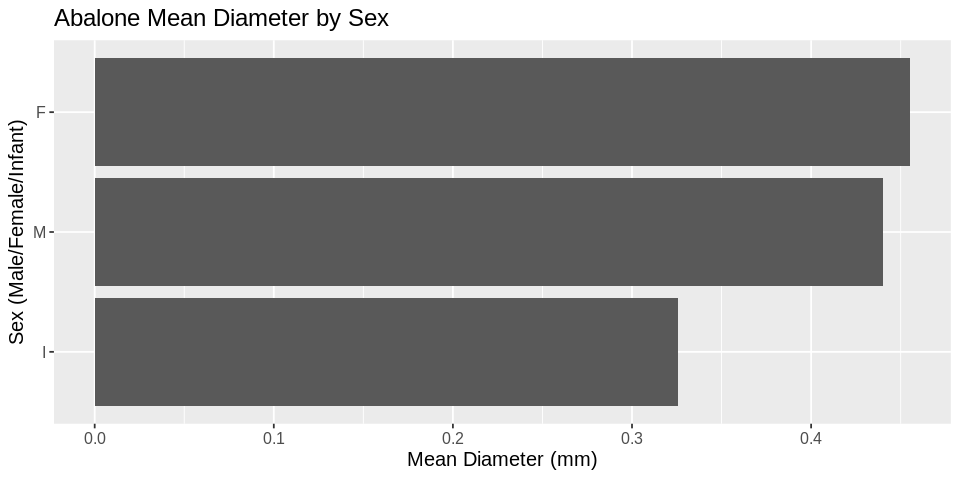

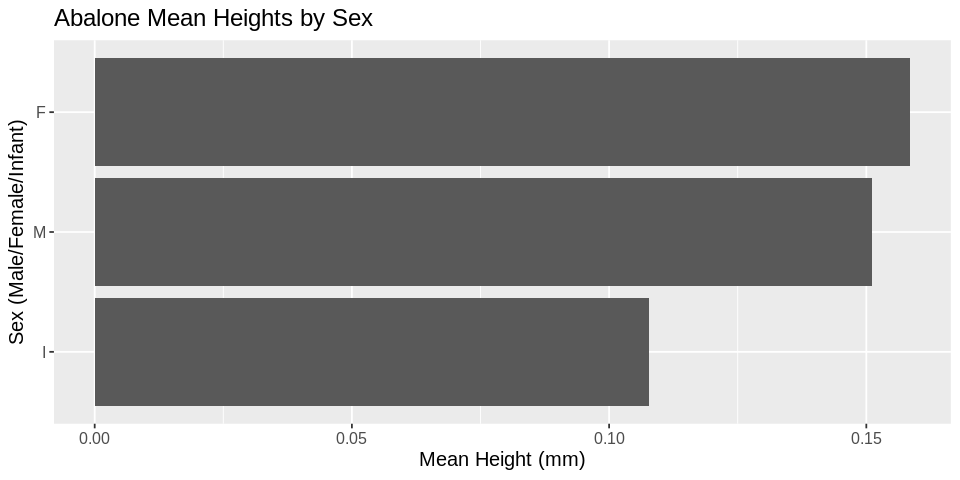

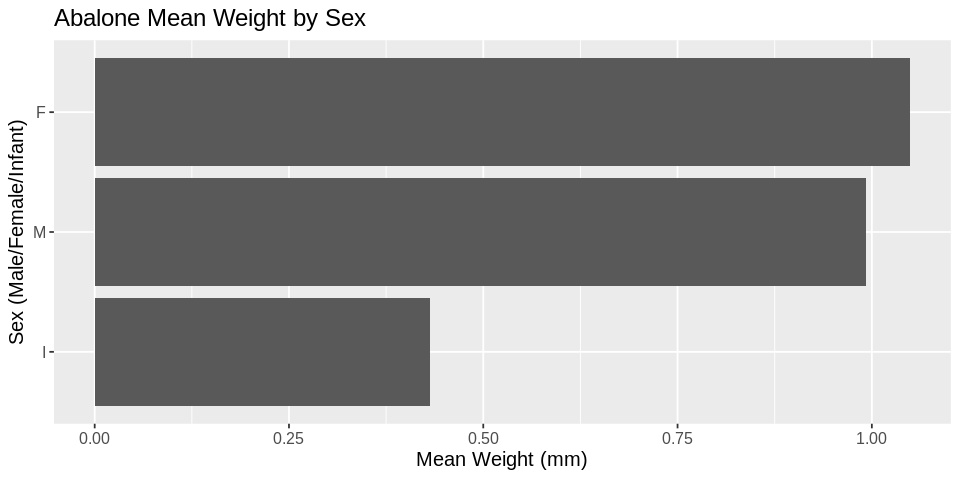

In [9]:
abalone_graph_diameter <- abalone_summarize |>
        ggplot(aes(x=mean_diameter, 
                   y=fct_reorder(sex, mean_diameter))) +
        geom_bar(stat="identity") +
        labs(x = "Mean Diameter (mm)", y = "Sex (Male/Female/Infant)", title="Abalone Mean Diameter by Sex") +
        theme(text = element_text(size = 12))

abalone_graph_height <- abalone_summarize |>
        ggplot(aes(x=mean_height, 
                   y=fct_reorder(sex, mean_height))) +
        geom_bar(stat="identity") +
        labs(x = "Mean Height (mm)", y = "Sex (Male/Female/Infant)", title="Abalone Mean Heights by Sex") +
        theme(text = element_text(size = 12))

abalone_graph_weight <- abalone_summarize |>
        ggplot(aes(x=mean_weight, 
                   y=fct_reorder(sex, mean_weight))) +
        geom_bar(stat="identity") +
        labs(x = "Mean Weight (mm)", y = "Sex (Male/Female/Infant)", title="Abalone Mean Weight by Sex") +
        theme(text = element_text(size = 12))

abalone_graph_diameter
abalone_graph_height
abalone_graph_weight

In [10]:
# !!! TODO
"For the summary table and visualizations, they are good, but should include some explanations - 
what does this tell you about the variables and its relationships? 
Also include figure and table names."

# !!! TODO
"all tables need a figure/table number and a legend"
# try: (labs(caption="Figure 1.1: Plot of xyz"))

# for the report provide narrations as your code develops

[1] "For the summary table and visualizations, they are good, but should include some explanations - \nwhat does this tell you about the variables and its relationships? \nAlso include figure and table names."

[1] "all tables need a figure/table number and a legend"

## Methods & Results - Classification

#### Evelyn's Code Begins Here:

`!!!TODO`, but basic idea is we tune for the optimal value of $k$. Unfortunately this method of 10-fold cross validation **takes around 4 minutes to run EVEN WITH $k \in [38,42]$,** so we may need to simplify for the final report. As such, the code is commented out for now to avoid stalls.

In [11]:
#Evelyn's Code

set.seed(3000)

abalone_recipe <- recipe(sex ~ length + diameter + height + weight, data = abalone_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors()) 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |> 
    set_mode("classification") 
  
abalone_vfold <- vfold_cv(abalone_train, v = 10, strata = sex) 
  
  
k_vals <- tibble(neighbors = seq(from = 38, to = 42, by = 1))

knn_results <- workflow() |> 
    add_recipe(abalone_recipe) |> 
    add_model(knn_spec) |> 
    tune_grid(resamples = abalone_vfold, grid = k_vals) |> 
    collect_metrics()

accuracies <- knn_results |> 
    filter(.metric == "accuracy") |>
    arrange(by = desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
40,accuracy,multiclass,0.5418667,10,0.007725740,Preprocessor1_Model3
39,accuracy,multiclass,0.5418606,10,0.007584951,Preprocessor1_Model2
38,accuracy,multiclass,0.5418586,10,0.008451512,Preprocessor1_Model1
41,accuracy,multiclass,0.5415401,10,0.007746370,Preprocessor1_Model4
42,accuracy,multiclass,0.5412216,10,0.007639992,Preprocessor1_Model5


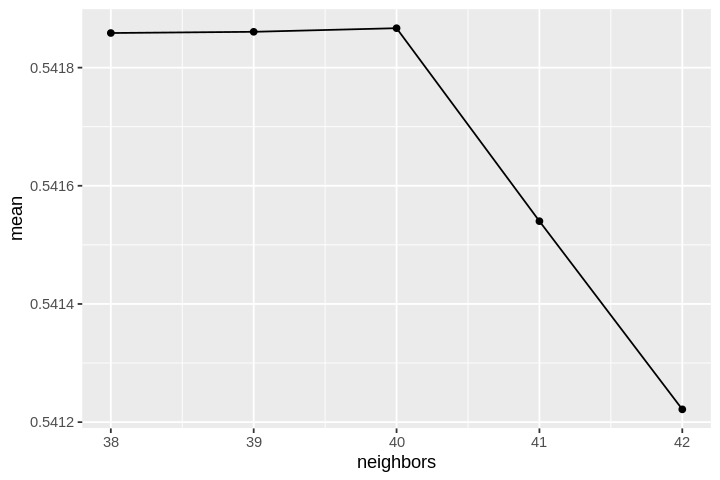

In [12]:
options(repr.plot.width = 6, repr.plot.height = 4)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line()

accuracy_vs_k

- With our optimal value of $k$ discovered, we can now run our model against the testing data with the optimal $k$. 
- We can reuse our `recipe` (although it is shown again here to remind the reader), and we are to create a new `spec` with the correct value of $k$.
- With those established, we can put it into a `workflow` and make our predictions.
- Using those results, we can manipulate the resulting dataframe, `abalone_predictions`, and `pull()` to conclude our accuracy:

In [13]:
set.seed(3000)

abalone_recipe <- recipe(sex ~ length + diameter + height + weight, data = abalone_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())

tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 40) |> 
    set_engine("kknn") |> 
    set_mode("classification") 

tuned_fit <- workflow() |> 
    add_recipe(abalone_recipe) |> 
    add_model(tuned_spec) |>
    fit(data = abalone_train)

abalone_predictions <- predict(tuned_fit, abalone_test) |> 
    bind_cols(abalone_test)
  
test_accuracy <- abalone_predictions |> 
    metrics(truth = sex, estimate = .pred_class) |> 
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

test_accuracy

[1] 0.5473684

In [14]:
# !!! TODO

"explanation / discussion of a lower than expected accuracy"

[1] "explanation / discussion of a lower than expected accuracy"

## Method & Results - Visualization

In [15]:
# !!! TODO

"put viz here"

[1] "put viz here"

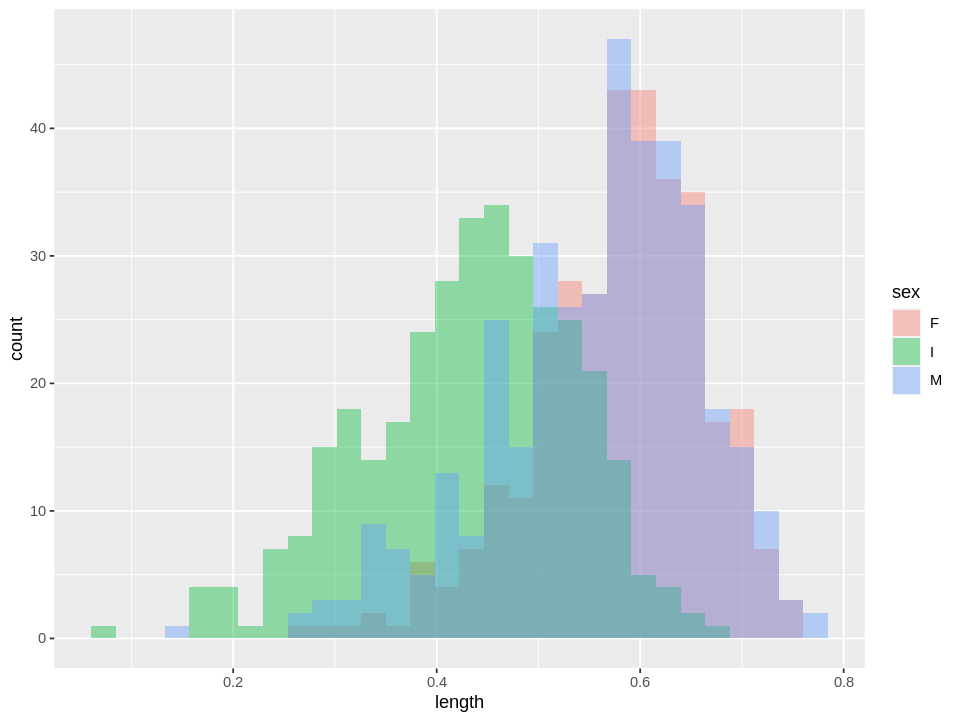

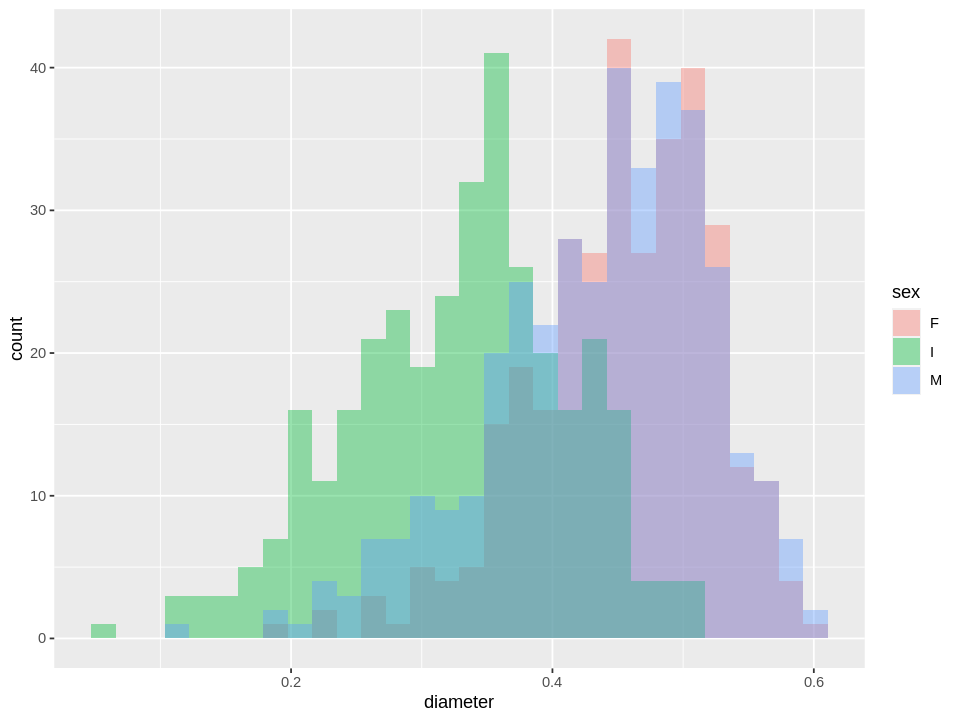

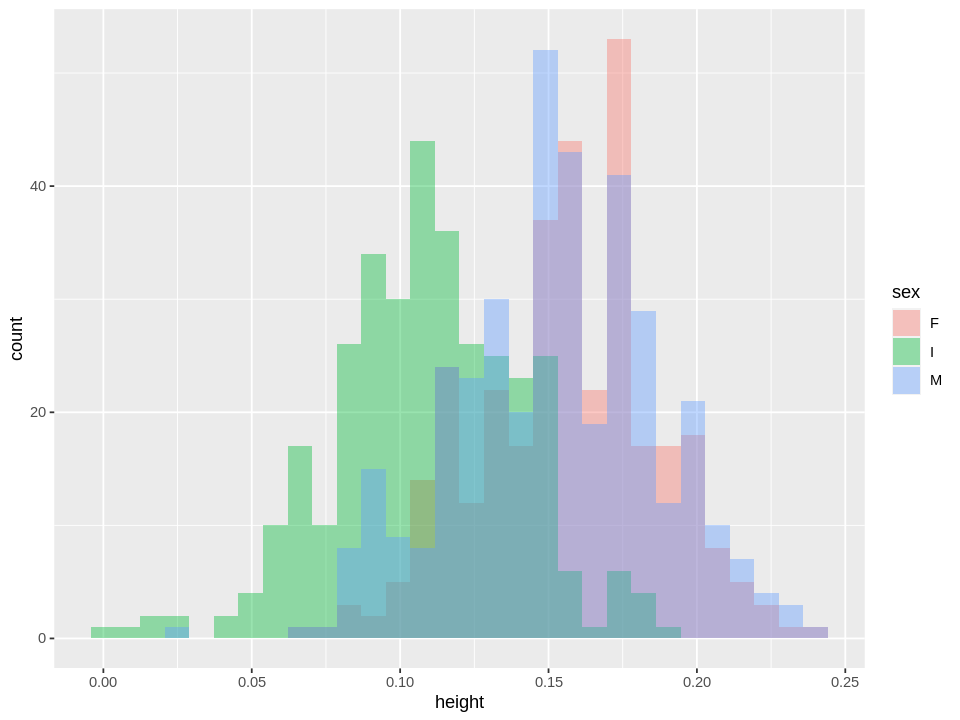

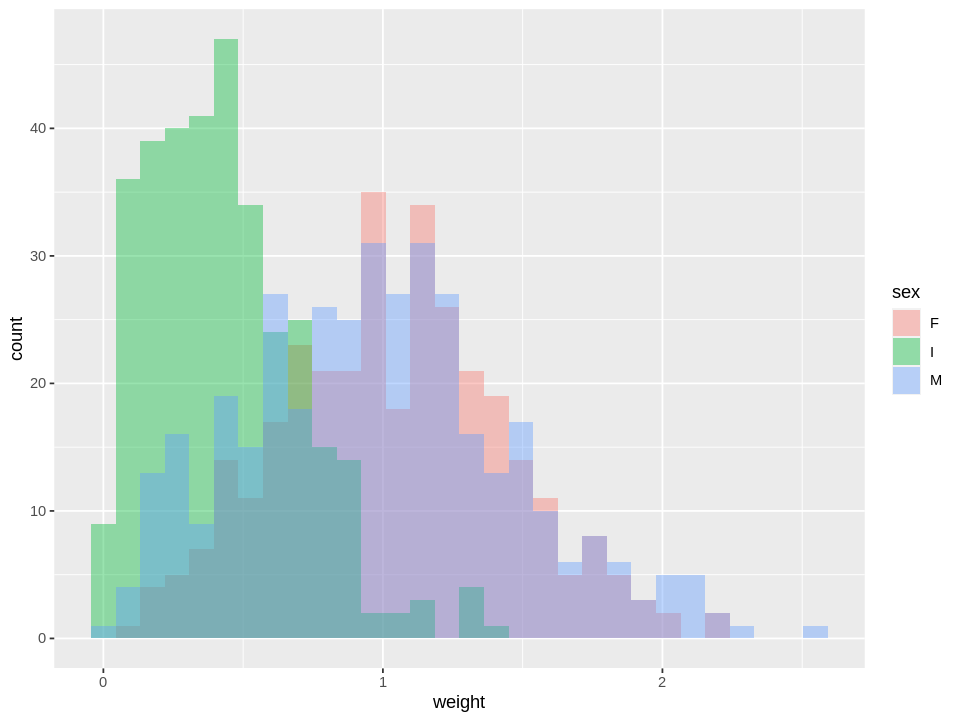

In [16]:
## possibility #1 -- histograms
options(repr.plot.width = 8, repr.plot.height = 6)

length_hist <- abalone_test |>
    ggplot(aes(x = length, fill = sex)) +
    geom_histogram(position="identity", alpha=0.4, bins=30)

length_hist


diameter_hist <- abalone_test |>
    ggplot(aes(x = diameter, fill = sex)) +
    geom_histogram(position="identity", alpha=0.4, bins=30)

diameter_hist


height_hist <- abalone_test |>
    ggplot(aes(x = height, fill = sex)) +
    geom_histogram(position="identity", alpha=0.4, bins=30)

height_hist


weight_hist <- abalone_test |>
    ggplot(aes(x = weight, fill = sex)) +
    geom_histogram(position="identity", alpha=0.4, bins=30)

weight_hist

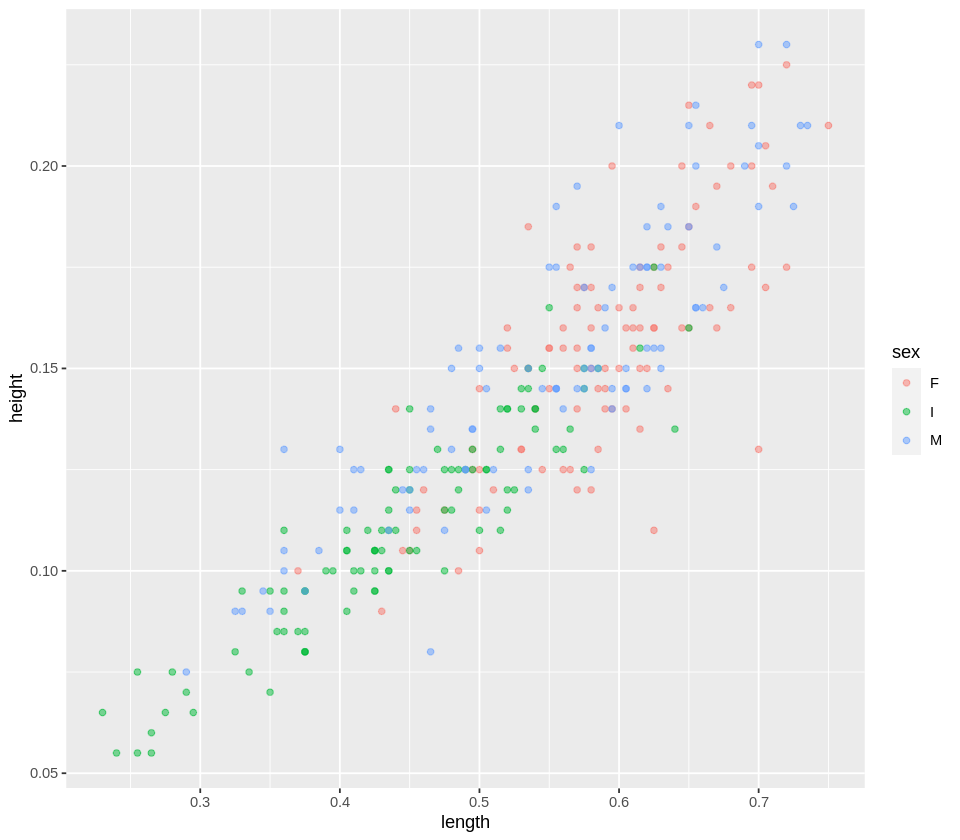

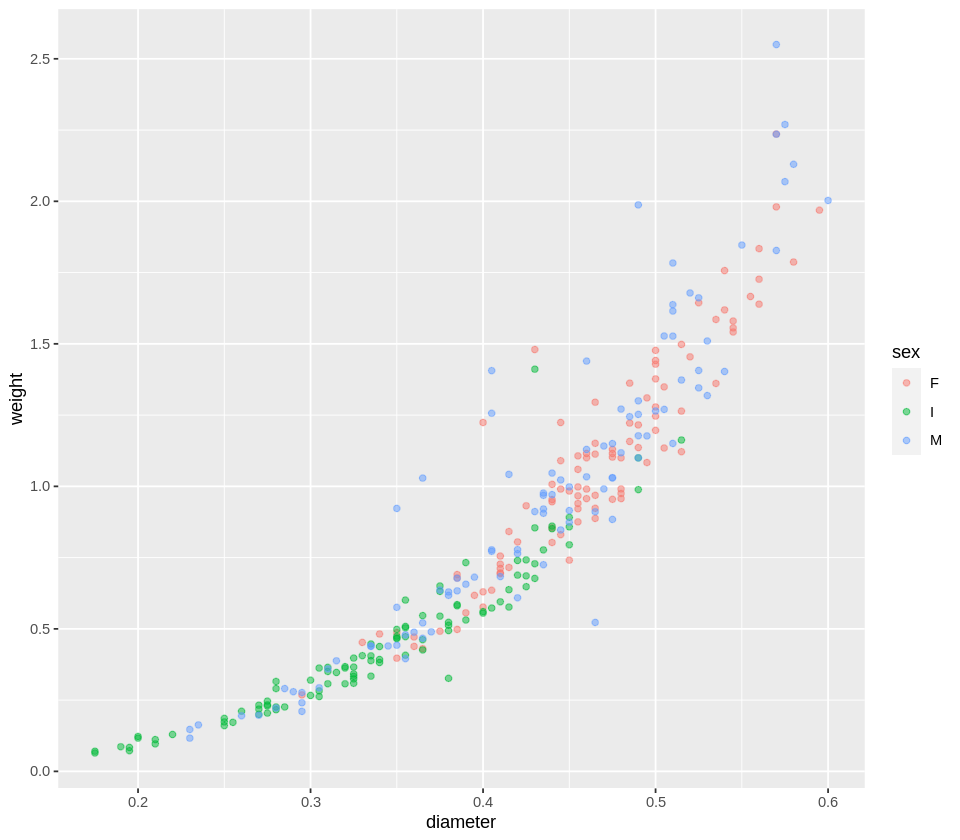

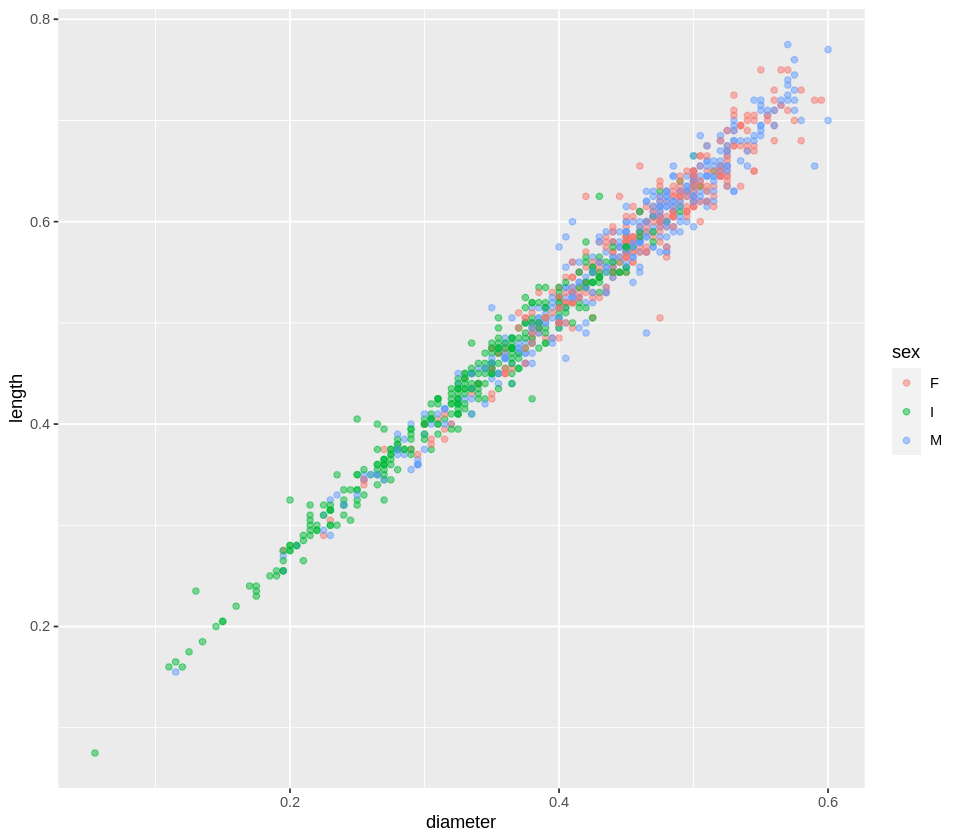

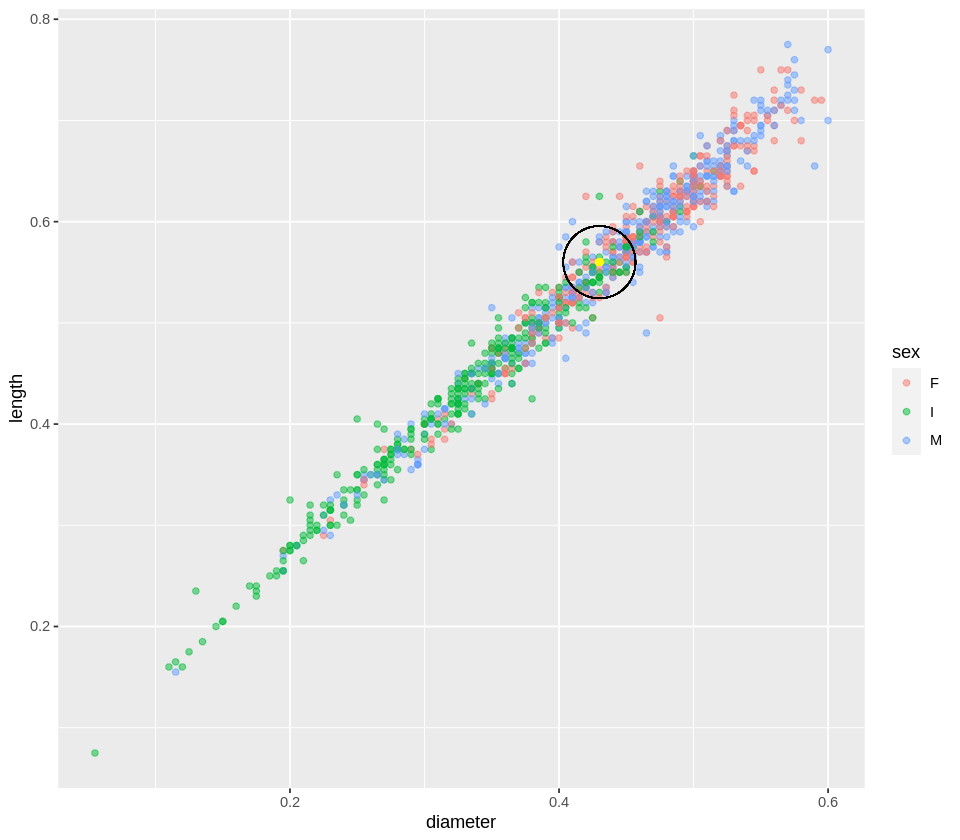

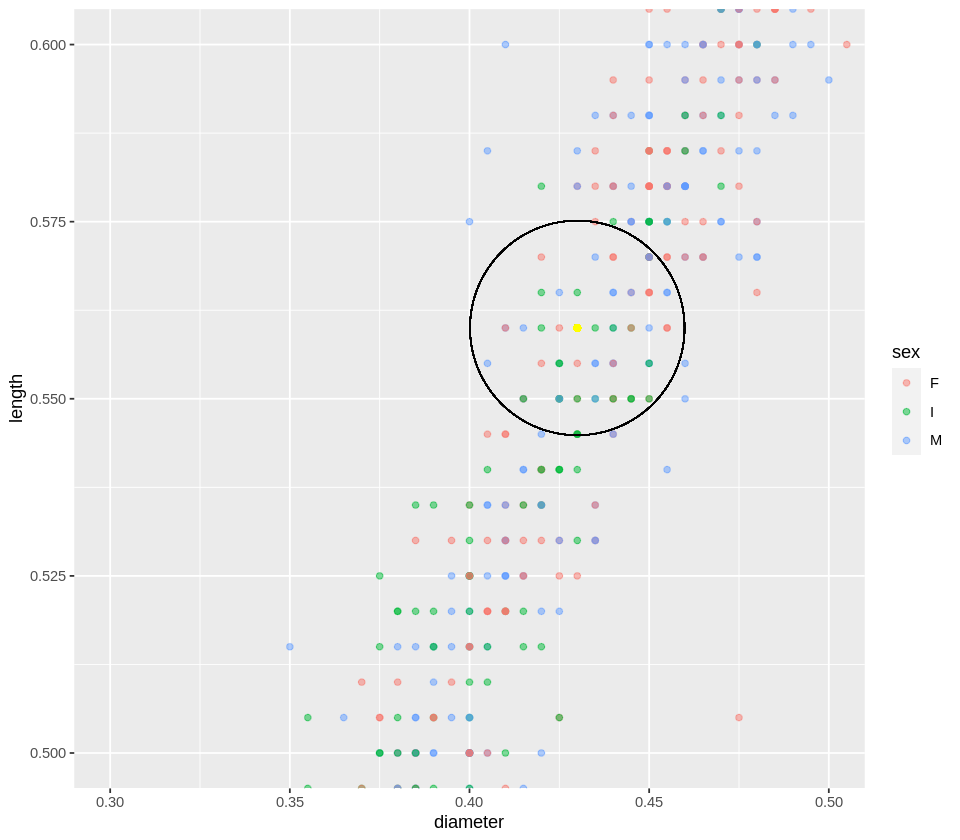

In [17]:
## possibility #2 -- plotting (small samples) for kmeans
set.seed(3000)
options(repr.plot.width = 8, repr.plot.height = 7)

## Take sample with (strata=sex) @ 100 observations per
small_abalone <- abalone_test |>
    group_by(sex) |>
    sample_n(size=100)

## Plot how KNN may struggle with, for ex, length vs. height
small_abalone_plot <- small_abalone |>
    ggplot(aes(x=length, y=height, color=sex)) +
    geom_point(alpha=0.5)

small_abalone_plot

## Plot showing where KNN may struggle wtih, for ex, diameter vs. weight
small_abalone_plot2 <- small_abalone |>
    ggplot(aes(x=diameter, y=weight, color=sex)) +
    geom_point(alpha=0.5)

small_abalone_plot2

## To demonstrate this is not a coincidence with the sample we have, consider a case where K=40 may struggle in accuracy
big_plot <- abalone_test |>
    ggplot(aes(x=diameter, y=length, color=sex)) +
    geom_point(alpha=0.5)

big_plot

## now consider a case which the model got wrong:
# .pred_class = F
# sex = M
# length = 0.560
# diameter = 0.43

big_plot2 <- abalone_test |>
    ggplot(aes(x=diameter, y=length, color=sex)) +
    geom_point(alpha=0.5) + 
    geom_point(aes(x=0.43,y=0.56), color="yellow") +
    geom_point(aes(x=0.43,y=0.56), color="black", size=20, pch=1)

big_plot2


# zooming in
big_plot3 <- abalone_test |>
    ggplot(aes(x=diameter, y=length, color=sex)) +
    geom_point(alpha=0.5) + 
    geom_point(aes(x=0.43,y=0.56), color="yellow") +
    geom_point(aes(x=0.43,y=0.56), color="black", size=60, pch=1) +
    coord_cartesian(xlim = c(0.3, 0.5), ylim = c(0.5,0.6))

big_plot3

In [18]:
## !!! TODO

"explanations for our viz"

[1] "explanations for our viz"

### (OLD ver.) Methods
**Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?**

- We will conduct our data analysis by first loading out abalone data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone) into R. We will then divide our data into $75\%$ training data and $25\%$ testing data. After creating a recipe, we will standardize our data (center and scale) focusing on the variables of `length`, `diameter`, `height`, and `weight`. Next, we will perform the classification of the effective gender by putting the standardized data into a workflow. Using the workflow, we will predict against the testing data and determine our prediction’s accuracy.

- We will visualize our results with a scatterplot circling a given unknown point (from the testing data) and the neighbouring $k$ points categorized by colour (for each gender). We can also, for each predictor, create a histogram of the testing set and colour by gender. This will allow us to visualize the relative mean and the importance of each factor. This will likely require mapping some sort of rounding factor for each observation. By comparing both our visualization and prediction, we will conclude the gender of a given abalone and the mean of each variable for each specific gender.

### (OLD ver.) Expected Outcomes and Significance

**What do you expect to find?**

- The gender category of new abalones of unknown gender categories based on training data and the new abalones’ dimensions

**What impact could such findings have?**
- More efficient sale and logistics
- Easier and faster to classify new abalones using only their dimension data instead of having to analyze their organs
    - the alternative method requires taking each one out of the water and observing the colour of its reproductive organs, which is time-consuming. [(source)](https://www.marinebio.net/marinescience/06future/abrepro.htm)


**What future questions could this lead to?**
- What are the characteristics of abalones tagged expensive (i.e. what are the most significant metrics merchants use to price the abalones)?
- What are the evolutionary causes behind certain factors (weight, length) being higher or lower for a certain gender?


In [19]:
# !!! TODO
"If you're using sources, please cite it in a bibliography as well, using any format you'd like."

[1] "If you're using sources, please cite it in a bibliography as well, using any format you'd like."

## Discussion

**Summarize what you found**

**Discuss whether this is what you expected to find?**

**Discuss what impact could such findings have?**

**Discuss what future questions could this lead to?**


## References

*dump them here for now*

[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone)

[Marine Bio](https://www.marinebio.net/marinescience/06future/abrepro.htm)

[Agricultural Marketing Resource Centre](https://www.agmrc.org/commodities-products/aquaculture/aquaculture-non-fish-species/abalone)